In [1]:
import pickle
import numpy as np
import pandas as pd
import itertools
from mastml.mastml import Mastml
from mastml.feature_generators import ElementalFeatureGenerator, ElementalFractionGenerator
# from mastml.feature_generators import ElementalFeatureGenerator
import matplotlib.pyplot as plt


In [2]:

pfile_X = "Codes/bandgap_pbe_X.pickle"
pfile_Y = "Codes/bandgap_pbe_Y.pickle"

In [3]:
with open(pfile_X, 'rb') as f:
    data = pickle.load(f)

In [4]:
with open(pfile_Y, 'rb') as f:
    data_y = pickle.load(f)

In [5]:
x_clean = data[['composition', 'structure', 'space group']]
# print("x_clean", x_clean)

composition = x_clean['composition']
structure = x_clean['structure']

m = float("inf")

# foo = structure[m]
# compositions = [composition[i] for i in range(m)]
compositions = [comp for i, comp in enumerate(composition) if i < m]

# sites = foo['sites']
# print("compositions", compositions)
print("num compositions", len(compositions))

num compositions 74992


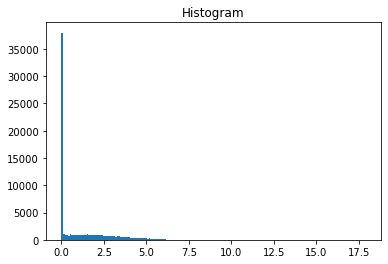

In [6]:
data_y
_ = plt.hist(data_y, bins='auto')
plt.title("Histogram")
plt.show()

In [7]:
# df = pd.DataFrame([compositions])
df = pd.DataFrame(compositions)
# print("df", df)
# e = ElementalFeatureGenerator(df)
e = ElementalFractionGenerator(df)
e.fit()
x, _ = e.transform(fraction=False)
print("vector shape", x.shape, "y", _)


vector shape (74992, 118) y None


In [8]:
x

,H,He,Li,Be,B,C,N,O,F,Ne,...,Mt,Ds,Rg,Cn,Nh,Fl,Mc,Lv,Ts,Og
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,8.0,0.0,8.0,0.0,0.0,24.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74988,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
y = data_y
print(y)

       bandgap value (eV)
0                   0.001
1                   0.001
2                   0.001
3                   0.001
4                   0.001
...                   ...
74987               0.000
74988               0.000
74989               0.000
74990               0.000
74991               0.000

[74992 rows x 1 columns]


In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, Matern, ConstantKernel
import time

In [11]:
# list(x.items())
# print(*x.items(), sep="\n")
# print(x.iloc[0])

## verify rows sum to 1
# total = x.sum(axis=1, numeric_only= True)
# print("total", total)

# material_group_char = ["O", "B", "F", "Cl", "Br", "I"]
material_group_char = ["O"]
for mat in material_group_char:
    print("Grouping for", mat)
    st1 = 100
    st2 = 10
    thresholds = [0]

    for th in thresholds:
        # Make split
        group_X = x[x[mat] > th]
        not_group_X = x[x[mat] <= th]
        # TODO: split for y based on split in X
        # group_y = [None for x in group_X]
        # not_group_y = [None for x in not_group_y]
        group_y = y[x[mat] > th]
        not_group_y = y[x[mat] <= th]

        perc_in_group = group_X.shape[0]/x.shape[0]
        print(f"\ttheshold:\t{th}\n\tpercent in {mat}_group:\t{perc_in_group}")
        # if the split leaves an empty group skip
        if perc_in_group == 0:
            continue
        
        # do GPR stuff
        print(f"Doing GPR for {mat}")
        gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(1e-1) # TODO: use the correct kernels specified by Ryan
        gpr = GaussianProcessRegressor(kernel=gp_kernel)
        stime = time.time()
        print("Start fitting")
        gpr.fit(group_X, group_y)
        print("Time for GPR fitting: %.3f" % (time.time() - stime))
        print("Done")

        # Predict using gaussian process regressor
        # stime = time.time()
        # y_gpr = gpr.predict(X_plot, return_std=False)
        # print("Time for GPR prediction: %.3f" % (time.time() - stime))


Grouping for O
	theshold:	0
	percent in O_group:	0.4545018135267762
Doing GPR for O


In [ ]:
gpr